In [4]:
import numpy as np
import pandas as pd
from numpy.linalg import norm, inv, eig, qr
from scipy.linalg import block_diag, svd 
import matplotlib.pyplot as plt
from sympy import Matrix, latex, symbols


# Model: 
$$\mathbf{d=m_1+m_2x+m_3x^2+m_4x^3}$$
# data:
$$d=
\begin{bmatrix}
d_1\\
d_2\\
\vdots\\
d_N
\end{bmatrix},\quad N=9$$
# parameters:
$$m=
\begin{bmatrix}
m_1\\
m_2\\
\vdots\\
m_M
\end{bmatrix},\quad M=4$$

In [5]:
class poly_fitting:          ### deg(p) -> 3

    def __init__(self,data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y
        self.N = len(self.data_x)     #data
        self.M = 4                    #parameters
        d_model = lambda x: [1,x,x**2,x**3]
        g_ij = [d_model(k) for k in self.data_x]
        self.G = np.array(g_ij) #kernel matrix
        self.d = np.array(self.data_y)
        m1,m2,m3,m4 = symbols('m_1 m_2 m_3 m_4')
        self.m = np.array([m1,m2,m3,m4])
        self.S = np.rot90(block_diag(self.G, self.G.T))
        #SVD (of the kernel matrix G):
        self.U, S, self.V = svd(self.G)
        f = lambda i,j: S[i] if i==j else 0    
        self.Sigma = np.array(Matrix(self.N, self.M, f), dtype=float)
        self.Sigma_p = np.diag(S)
        self.p = len(np.diag(S))
        self.U_p = self.U[:,:self.p]
        self.V_p = self.V[:,:self.p]
        
    def __repr__(self):
        return str(dict(zip(self.data_x,self.data_y)))
    def __str__(self):
        return self.__repr__()
    
    def df(self):
        data_df = pd.DataFrame({
                                    'X': self.data_x,
                                    'Y': self.data_y
                                })
        return data_df
    
    def give_eqs(self):
        m1,m2,m3,m4 = symbols("m_1 m_2 m_3 m_4")
        model_d = lambda x: np.dot(np.array([m1,m2,m3,m4]), np.array([1,x,x**2,x**3]))
        eq_d = Matrix([model_d(k) for k in self.data_x])
        return eq_d
    
    def plot_data(self,Color=None):
        if (Color==None): Color = 'red'
        plt.scatter(self.data_x, self.data_y,marker='.',color=Color)
        plt.xlabel('$\mathbf{x}:$ Horizontal distance (km)')
        plt.ylabel('$\mathbf{d}:$ Elevation (km)')
        plt.show()
        
    def least_squares(self):
        m_est = inv(self.G.T @ self.G) @ self.G.T @ self.d
        return m_est
    
    def d_pre(self):
        return self.G @ self.least_squares()
    
    def error(self,Norm=None):
        if (Norm == None): Norm = 2
        return norm(self.d - self.d_pre(), Norm)
    
    def plot_fitting(self):
        m_est = self.least_squares()
        plt.rcParams["figure.figsize"] = [7.50, 3.50]
        plt.rcParams["figure.autolayout"] = True
        p = lambda x: m_est[0] + m_est[1]*x + m_est[2] * x**2 + m_est[3] * x**3
        x = np.linspace(-5, 31, 250)
        plt.plot(x, p(x), color='red')
        plt.scatter(self.data_x, self.data_y, marker='.',color='black')
        plt.show()
        
    def SVD_kernel(self):
        return self.U @ self.Sigma @ self.V
    
    def pseudoinverse(self):
        G_g = self.V_p.T @ inv(self.Sigma_p) @ self.U_p.T
        return G_g
    def SVD_m_est(self):
        m_est = self.pseudoinverse()@self.d
        return m_est
    
    def SVD_d_pre(self):
        return self.G @ self.SVD_m_est()

    def plot_fitting_SVD(self):
        m_est = self.SVD_m_est()
        plt.rcParams["figure.figsize"] = [7.50, 3.50]
        plt.rcParams["figure.autolayout"] = True
        p = lambda x: m_est[0] + m_est[1]*x + m_est[2] * x**2 + m_est[3] * x**3
        x = np.linspace(-5, 31, 250)
        plt.plot(x, p(x), color='red')
        plt.scatter(self.data_x, self.data_y, marker='.',color='black')
        plt.show()
    
    def data_analysis_matrix_svd(self):
        N = self.U_p @ self.U_p.T # =self.G @ self.pseudoinverse()
        return N
    
    def par_analysis_matrix_svd(self):
        R = self.V_p.T @ self.V_p # =self.pseudoinverse() @ self.G 
        return R
    def cov_u_m(self):
        return self.pseudoinverse() @ self.pseudoinverse().T
    
    def cov_u_mest(self):
        size = len(self.par_analysis_matrix_svd())
        H = (np.eye(size) - self.par_analysis_matrix_svd())
        cov = self.cov_u_m() + H@self.cov_u_m()@H
        return cov
    
    def spread_N(self):
        size = self.data_analysis_matrix_svd().shape[0]
        return norm(self.data_analysis_matrix_svd() - np.eye(size), 'fro')**2
    
    def k(self):
        return norm(self.G,'fro')*norm(self.pseudoinverse(),'fro')
    
    
def format_matrix(matrix, demical=None, latex=None): #format(. ,"n.f") but for matrices
    if (demical==None): demical= "."+str(5)+"f"
    else:
        demical = "."+str(demical)+"f"
    f_oper = lambda arr: np.array([float(format(arr[i],demical)) for i in range(len(arr))])    
    if latex==True:
        return Matrix(np.array(list(map(f_oper, matrix))))
    return np.array(list(map(f_oper, matrix)))



In [6]:
data_x = np.array([1,2,3,5,6,12,15,20,30])
data_y = np.array([23,49,107,442,905,8700,13200,38440,215300])

model = poly_fitting(data_x,data_y)

In [7]:
model.df()

,X,Y
0,1,23
1,2,49
2,3,107
3,5,442
4,6,905
5,12,8700
6,15,13200
7,20,38440
8,30,215300


In [8]:
model.give_eqs()

Matrix([
[             m_1 + m_2 + m_3 + m_4],
[       m_1 + 2*m_2 + 4*m_3 + 8*m_4],
[      m_1 + 3*m_2 + 9*m_3 + 27*m_4],
[    m_1 + 5*m_2 + 25*m_3 + 125*m_4],
[    m_1 + 6*m_2 + 36*m_3 + 216*m_4],
[ m_1 + 12*m_2 + 144*m_3 + 1728*m_4],
[ m_1 + 15*m_2 + 225*m_3 + 3375*m_4],
[ m_1 + 20*m_2 + 400*m_3 + 8000*m_4],
[m_1 + 30*m_2 + 900*m_3 + 27000*m_4]])

In [9]:
Matrix(model.G)

Matrix([
[1,  1,   1,     1],
[1,  2,   4,     8],
[1,  3,   9,    27],
[1,  5,  25,   125],
[1,  6,  36,   216],
[1, 12, 144,  1728],
[1, 15, 225,  3375],
[1, 20, 400,  8000],
[1, 30, 900, 27000]])

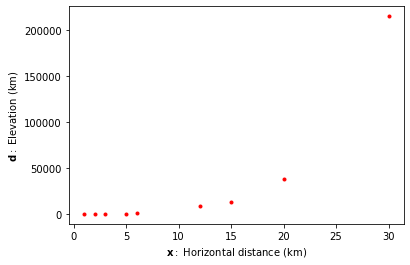

In [10]:
model.plot_data()

In [11]:
Matrix(model.least_squares()) #normal eq

Matrix([
[-4526.12816835896],
[  2881.0401528196],
[-385.877006164702],
[  17.787867537097]])

In [12]:
Matrix(model.d_pre())

Matrix([
[-2013.17715416696],
[ -165.25294708179],
[ 1124.37165811914],
[ 2455.63088375861],
[ 2710.71991464232],
[ 5217.49988186275],
[ 11901.2006745794],
[ 41046.8127189282],
[ 214888.194369616]])

In [13]:
model.error()

5772.524902909619

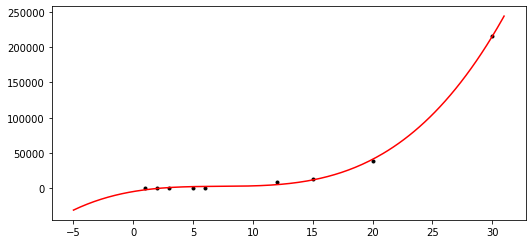

In [14]:
model.plot_fitting()

In [15]:
Matrix(format_matrix(model.SVD_kernel())) # SVD analysis of G

Matrix([
[1.0,  1.0,   1.0,     1.0],
[1.0,  2.0,   4.0,     8.0],
[1.0,  3.0,   9.0,    27.0],
[1.0,  5.0,  25.0,   125.0],
[1.0,  6.0,  36.0,   216.0],
[1.0, 12.0, 144.0,  1728.0],
[1.0, 15.0, 225.0,  3375.0],
[1.0, 20.0, 400.0,  8000.0],
[1.0, 30.0, 900.0, 27000.0]])

In [16]:
Matrix(format_matrix(model.pseudoinverse()))

Matrix([
[ 0.74274,  0.46818,  0.23894, -0.09584, -0.20754, -0.29186, -0.09581,  0.29675, -0.05557],
[-0.21345,  -0.1006, -0.00821,  0.12101,  0.16072,   0.1414,  0.03117, -0.16669,  0.03464],
[ 0.01503,  0.00614, -0.00103, -0.01077, -0.01357, -0.00938,  0.00063,  0.01744, -0.00449],
[-0.00029, -0.00011,   4.0e-5,  0.00023,  0.00028,  0.00017,  -5.0e-5, -0.00041,  0.00015]])

In [17]:
Matrix(model.SVD_m_est())

Matrix([
[-4526.12816842002],
[ 2881.04015282435],
[ -385.87700616485],
[ 17.7878675370993]])

In [18]:
Matrix(model.SVD_d_pre())

Matrix([
[-2013.17715422342],
[-165.252947133924],
[ 1124.37165807106],
[ 2455.63088371789],
[ 2710.71991460492],
[ 5217.49988184133],
[ 11901.2006745641],
[ 41046.8127189212],
[ 214888.194369626]])

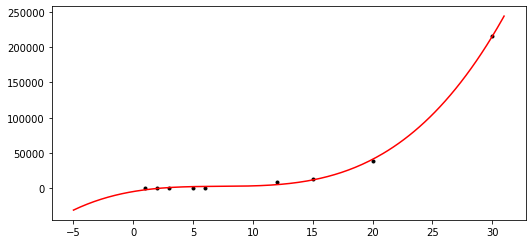

In [19]:
model.plot_fitting_SVD()

In [20]:
Matrix(model.Sigma_p)

Matrix([
[28433.2271452483,                0,             0,                 0],
[               0, 190.725843261241,             0,                 0],
[               0,                0, 5.82360392825,                 0],
[               0,                0,             0, 0.919273117414761]])

In [21]:
Matrix(format_matrix(model.U_p))

Matrix([
[ -4.0e-5,   0.0056,  0.20028,  0.70984],
[-0.00029,  0.02047,  0.31448,  0.43743],
[-0.00096,  0.04355,  0.39969,  0.21054],
[-0.00442,   0.1099,  0.49229, -0.11914],
[-0.00764,  0.15095,  0.50425, -0.22814],
[-0.06092,  0.43768,  0.23907, -0.29585],
[-0.11891,  0.55712, -0.00732, -0.09257],
[-0.28168,  0.61725, -0.37339,  0.30769],
[-0.95012, -0.28256,  0.08944, -0.05865]])

In [22]:
Matrix(format_matrix(model.V_p))

Matrix([
[-5.0e-5, -0.00129, -0.0353, -0.99938],
[ 0.0087,  0.10019, 0.99431, -0.03525],
[0.31918,  0.94264, -0.0977,  0.00222],
[0.94765, -0.31841, 0.02377, -0.00048]])

In [23]:
Matrix(format_matrix(model.data_analysis_matrix_svd()))

Matrix([
[ 0.54402,  0.37361,  0.22974,  0.01464, -0.06011, -0.15967, -0.06405,   0.1471, -0.02527],
[ 0.37361,  0.29066,  0.21868,  0.10495,  0.06187, -0.04525, -0.03136,  0.02989, -0.00304],
[ 0.22974,  0.21868,  0.20597,  0.17647,  0.16009,  0.05239,  0.00196, -0.05731,  0.01201],
[ 0.01464,  0.10495,  0.17647,  0.26864,  0.29204,  0.20131,  0.06918, -0.15139,  0.02417],
[-0.06011,  0.06187,  0.16009,  0.29204,  0.32915,  0.25458,  0.10244, -0.16315,  0.02308],
[-0.15967, -0.04525,  0.05239,  0.20131,  0.25458,  0.33996,  0.27672,  0.10702, -0.02706],
[-0.06405, -0.03136,  0.00196,  0.06918,  0.10244,  0.27672,  0.33315,  0.35163, -0.03967],
[  0.1471,  0.02989, -0.05731, -0.15139, -0.16315,  0.10702,  0.35163,  0.69444,  0.04178],
[-0.02527, -0.00304,  0.01201,  0.02417,  0.02308, -0.02706, -0.03967,  0.04178,    0.994]])

In [24]:
Matrix(format_matrix(model.par_analysis_matrix_svd()))

Matrix([
[1.0,   0,   0,   0],
[  0, 1.0,   0,   0],
[  0,   0, 1.0,   0],
[  0,   0,   0, 1.0]])

In [25]:
Matrix(format_matrix(model.cov_u_m()))

Matrix([
[  1.0657,  -0.3482,  0.02574, -0.00051],
[ -0.3482,  0.14618, -0.01167,  0.00024],
[ 0.02574, -0.01167,  0.00098,  -2.0e-5],
[-0.00051,  0.00024,  -2.0e-5,        0]])

In [26]:
float(format(model.spread_N(),".4f"))

5.0

In [28]:
model.k() #cond number

31314.15973350633

--------

### $$\textbf{John Mars}$$

----------